In [41]:
import pandas as pd
import seaborn as sns
import numpy as np

# Select block size for parallelizing traf.py

In [5]:
df = pd.read_csv('./select_traf_blocksize/blocksize.tsv', sep='\t', header=None)
df =  df.rename(columns={0:'file',1:'size',2:'bs',3:'time'})
df.head()

,file,size,bs,time,4
0,/users/arefevni/hplt/two/html_sample0.01_bs10/...,2112108,3M,1m32.384s,NaN
1,/users/arefevni/hplt/two/html_sample0.01_bs10/...,1531912,3M,0m57.249s,NaN
2,/users/arefevni/hplt/two/html_sample0.01_bs10/...,1652148,3M,1m11.109s,NaN
3,/users/arefevni/hplt/two/html_sample0.01_bs10/...,1948860,3M,1m23.885s,NaN
4,/users/arefevni/hplt/two/html_sample0.01_bs10/...,1040888,3M,0m48.125s,NaN


In [24]:
df.time = pd.to_datetime(df.time, format='%Mm%S.%fs') - pd.to_datetime('0', format='%S')

In [26]:
df.time = df.time.dt.total_seconds()

In [36]:
df['size-bin'] = pd.qcut(df['size'] / 2**20, q=10)

In [54]:
df['size-bin-left'] = df['size-bin'].apply(lambda r: r.left)

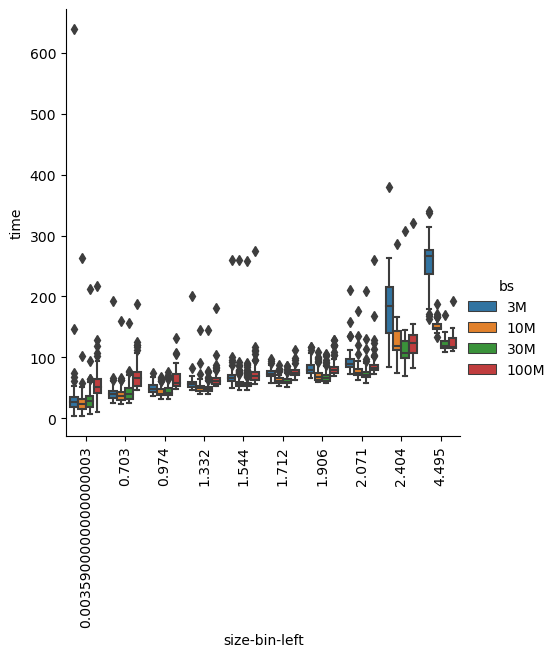

In [59]:
g =  sns.catplot(data=df, x='size-bin-left', y='time', hue='bs', kind='box')
g.set_xticklabels(rotation=90)

Block size 100 MB is suboptimal for files < 2.5 GB. Probably not all cpus are occupied.
Block size 3 MB is very suboptimal for files > 2 GB. Init cost starts playing its role.
Block size 30 MB looks best accross the experimental range.
##### Block size 30 MB for trafilatura is selected

# Select traf.py timeout

In [75]:
dfd = pd.read_csv('./select_traf_timeout/dur_nofallback_sampled.zst', header=None)
dfd.head()

,0
0,0.0088
1,0.0071
2,0.0270
3,0.0130
4,0.0013


In [95]:
dfd[0].describe(percentiles=[.95,.99,.995,.997,.999])

count    1000000.000000
mean           0.034255
std            0.133266
min            0.000100
50%            0.014000
95%            0.120000
99%            0.310000
99.5%          0.450000
99.7%          0.570000
99.9%          1.100000
max           37.000000
Name: 0, dtype: float64

<Axes: ylabel='Proportion'>

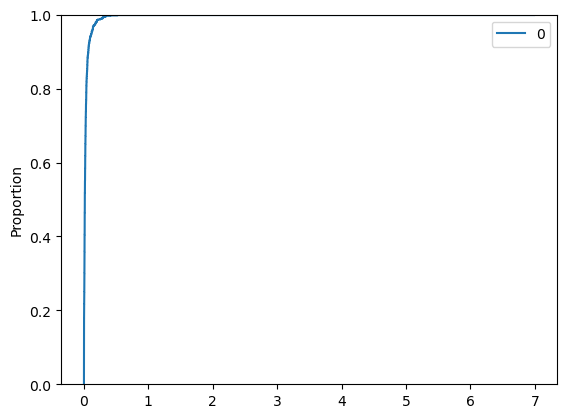

In [77]:
sns.ecdfplot(dfd.sample(1000))

In [89]:
!pwd

/home/nikolare/_projects/hplt/warc2text-runner/two/stage2_hypers


In [90]:
dfc = pd.read_csv('./select_traf_timeout/doc_cnts_portion1.zst', header=None)
dfc.head()

,0
0,19538214
1,19449774
2,19933541
3,19737386
4,19829708


We have 2 days = 48 hours time limit for bs=1000

In [97]:
timeout = 0.5 #seconds
nproc = 200
((dfc[0] / nproc * timeout) / 3600).describe()

count    2581.000000
mean       13.975669
std         5.819919
min         1.341302
25%        10.908780
50%        13.361026
75%        14.036738
max        37.781899
Name: 0, dtype: float64

Even if it takes 0.5s for each doc, we should fit.
##### Select timout 0.5s, should loose less than 0.5% of docs

In [100]:
secperdoc_avg = dfd[0].mean()
print(secperdoc_avg)

0.03425524465000001


In [105]:
(dfc*secperdoc_avg / nproc / 3600).describe()

,0
count,2581.000000
mean,0.957480
std,0.398725
min,0.091893
25%,0.747366
50%,0.915370
75%,0.961664
max,2.588456


Stage2 for 1 input file should take 1h on avg, 2.6h maximum